<a href="https://colab.research.google.com/github/Hur-Ali110/Data-Science-Intern-P2-/blob/main/Intern(Task_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load and preprocess data
df = pd.read_csv('/content/household_power_consumption.csv', low_memory=False)

# Convert Date and Time to datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Convert to numeric (handle any non-numeric values)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
df = df.dropna()

# Resample to hourly frequency for more stable forecasting
hourly_df = df.resample('H').mean()

# Use Global_active_power as the target variable for forecasting
target_series = hourly_df['Global_active_power']

# Split into train and test (last 168 hours = 1 week for testing)
train_size = int(len(target_series) * 0.8)
train, test = target_series[:train_size], target_series[train_size:]

In [ ]:
print(f"Training data: {len(train)} hours")
print(f"Test data: {len(test)} hours")
print(f"Total data points: {len(target_series)}")

Training data: 1782 hours
Test data: 446 hours
Total data points: 2228


In [ ]:
# 1. ARIMA Model
def fit_arima(train_data, test_data):
    # Fit ARIMA model
    model = ARIMA(train_data, order=(2,1,2))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test_data))

    return forecast, model_fit

In [ ]:
# 2. Prophet Model
def fit_prophet(train_data, test_data):
    # Prepare data for Prophet
    prophet_df = train_data.reset_index()
    prophet_df.columns = ['ds', 'y']

    # Fit Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.fit(prophet_df)

    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test_data), freq='H')

    # Forecast
    forecast_df = model.predict(future)
    forecast = forecast_df['yhat'].iloc[-len(test_data):].values

    return forecast, model

Training ARIMA model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2g4uxf6/w76h2a2j.json


Training Prophet model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpe2g4uxf6/s3bu4miq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80219', 'data', 'file=/tmp/tmpe2g4uxf6/w76h2a2j.json', 'init=/tmp/tmpe2g4uxf6/s3bu4miq.json', 'output', 'file=/tmp/tmpe2g4uxf6/prophet_modelmb7z7n8_/prophet_model-20250831121700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Training XGBoost model...

Model Performance Comparison:
  Model      MAE     RMSE
  ARIMA 0.854222 1.217487
Prophet 3.783054 4.129831
XGBoost 0.028942 0.048535


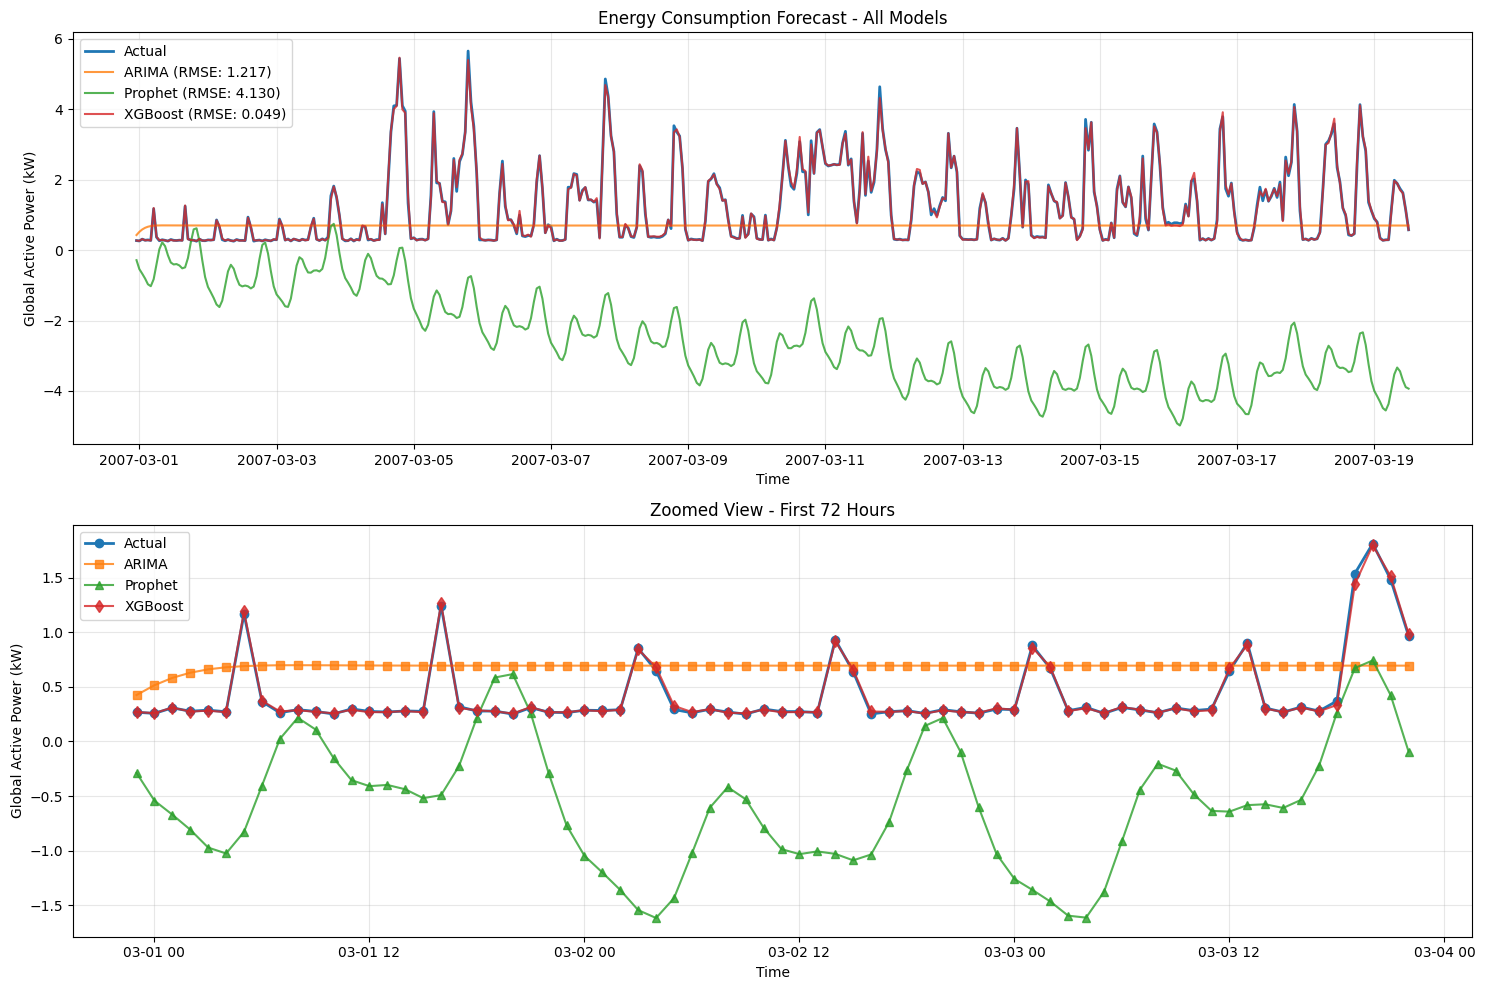

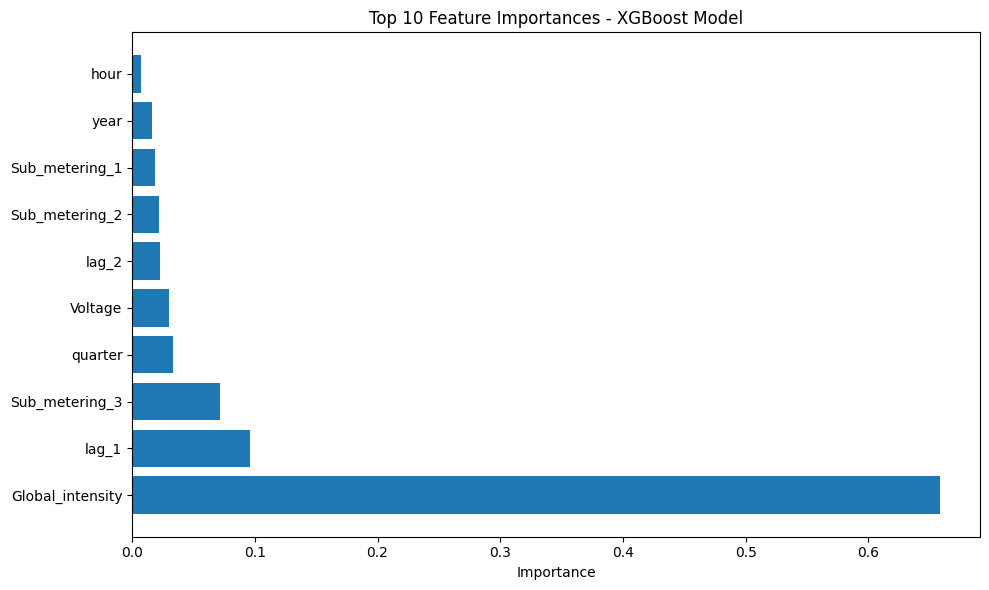


Best performing model: XGBoost

Forecast Statistics:
           Actual       ARIMA     Prophet     XGBoost
count  446.000000  446.000000  446.000000  446.000000
mean     1.227643    0.693188   -2.552387    1.227249
std      1.096290    0.016559    1.326955    1.088563
min      0.250133    0.425183   -4.978933    0.256100
25%      0.306242    0.694663   -3.630187    0.302194
50%      0.845717    0.694663   -2.760231    0.839998
75%      1.872517    0.694663   -1.587545    1.872757
max      5.644900    0.698665    0.742855    5.456967


In [ ]:
# 3. XGBoost Model with feature engineering
def create_features(df, target_col='Global_active_power'):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    for lag in [1, 2, 3, 24, 48, 168]:  # 1h, 2h, 3h, 24h, 48h, 1 week
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    return df

def fit_xgboost(train_data, test_data, full_df):
    # Create features
    feature_df = create_features(full_df)
    feature_df = feature_df.dropna()

    # Split features and target
    X = feature_df.drop('Global_active_power', axis=1)
    y = feature_df['Global_active_power']

    # Determine the split point based on the length of the processed feature_df
    train_split_idx = len(feature_df) - len(test_data)

    # Split train/test
    X_train, X_test = X.iloc[:train_split_idx], X.iloc[train_split_idx:]
    y_train, y_test = y.iloc[:train_split_idx], y.iloc[train_split_idx:]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    # Predict
    forecast = model.predict(X_test_scaled)

    return forecast, y_test, model, X_train.columns # Return y_test and X_train columns as well

# Train models and get forecasts
print("Training ARIMA model...")
arima_forecast, arima_model = fit_arima(train, test)

print("Training Prophet model...")
prophet_forecast, prophet_model = fit_prophet(train, test)

print("Training XGBoost model...")
xgboost_forecast, xgboost_y_test, xgboost_model, xgboost_features = fit_xgboost(train, test, hourly_df)

# Calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

arima_mae, arima_rmse = calculate_metrics(test, arima_forecast)
prophet_mae, prophet_rmse = calculate_metrics(test, prophet_forecast)
xgboost_mae, xgboost_rmse = calculate_metrics(xgboost_y_test, xgboost_forecast) # Use xgboost_y_test for metrics

# Create comparison table
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [arima_mae, prophet_mae, xgboost_mae],
    'RMSE': [arima_rmse, prophet_rmse, xgboost_rmse]
})

print("\nModel Performance Comparison:")
print(metrics_df.to_string(index=False))

# Plot actual vs forecast
plt.figure(figsize=(15, 10))

# Plot 1: All forecasts together
plt.subplot(2, 1, 1)
plt.plot(test.index, test.values, label='Actual', linewidth=2)
plt.plot(test.index, arima_forecast, label=f'ARIMA (RMSE: {arima_rmse:.3f})', alpha=0.8)
plt.plot(test.index, prophet_forecast, label=f'Prophet (RMSE: {prophet_rmse:.3f})', alpha=0.8)
# Plot XGBoost forecast using the xgboost_y_test index for alignment
plt.plot(xgboost_y_test.index, xgboost_forecast, label=f'XGBoost (RMSE: {xgboost_rmse:.3f})', alpha=0.8)
plt.title('Energy Consumption Forecast - All Models')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed in view (first 72 hours)
plt.subplot(2, 1, 2)
zoom_hours = 72
plt.plot(test.index[:zoom_hours], test.values[:zoom_hours], label='Actual', linewidth=2, marker='o')
plt.plot(test.index[:zoom_hours], arima_forecast[:zoom_hours], label='ARIMA', alpha=0.8, marker='s')
plt.plot(test.index[:zoom_hours], prophet_forecast[:zoom_hours], label='Prophet', alpha=0.8, marker='^')
# Plot XGBoost zoomed view using the xgboost_y_test index for alignment
plt.plot(xgboost_y_test.index[:zoom_hours], xgboost_forecast[:zoom_hours], label='XGBoost', alpha=0.8, marker='d')
plt.title('Zoomed View - First 72 Hours')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Feature importance for XGBoost
if hasattr(xgboost_model, 'feature_importances_'):
    # Correct the column names for feature importance
    feature_importance = pd.DataFrame({
        'feature': xgboost_features, # Use the returned feature names
        'importance': xgboost_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
    plt.title('Top 10 Feature Importances - XGBoost Model')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Residual analysis for the best model
best_model_name = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
print(f"\nBest performing model: {best_model_name}")

# Show summary statistics of forecasts
forecast_stats = pd.DataFrame({
    'Actual': test.describe(),
    'ARIMA': pd.Series(arima_forecast).describe(),
    'Prophet': pd.Series(prophet_forecast).describe(),
    'XGBoost': pd.Series(xgboost_forecast).describe()
})

print("\nForecast Statistics:")
print(forecast_stats)